# Introduction

## Import Libraries

In [1]:
import pandas_datareader.data as web
import pandas as pd
import yfinance as yf
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

### Defining Data Cleaning Function
If a ticker, in the list obtained from the Dow Jones Index, contains a NaN value, subsequent information on that ticker is removed from their corresponding lists. 

In [2]:
# Define the function to clean the DataFrame
def clean_stock_data(stock_data, tickers, company, industry):
    # Check for NaN values in the stock_data DataFrame
    nan_check = stock_data.isna().any()

    # Identify columns with NaN values
    columns_with_nan = nan_check[nan_check].index.tolist()

    if columns_with_nan:
        # Remove columns with NaN values
        stock_data_cleaned = stock_data.drop(columns=columns_with_nan)
        print(f"Removed columns with NaN values: {columns_with_nan}")

        # Remove the associated tickers from the list if they exist
        for col in columns_with_nan:
            ticker = col[1]

            if ticker in tickers:
                ticker_index = tickers.index(ticker)
                tickers.pop(ticker_index)
                company.pop(ticker_index)
                industry.pop(ticker_index)

        print(f"Removed tickers associated with NaN columns: {columns_with_nan}")

        return stock_data_cleaned, tickers, company, industry
    else:
        return stock_data, tickers, company, industry

## Obtaining Dow Jones Index Data
The company tickers for the Dow Jones Index are obtained from the falling URL: https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average.
The data is scraped from a table and then specific columns are assigned to specific variables.

In [3]:
# Read tables from the Wikipedia page
df_dow_jones_list = pd.read_html("https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average")

# Identify the correct DataFrame that contains DJIA data (you might need to check the list)
df_dow_jones = df_dow_jones_list[1]  # Change the index if needed

# Get the list of tickers
tickers = df_dow_jones['Symbol'].tolist()
company = df_dow_jones['Company'].tolist()
industry = df_dow_jones['Industry'].tolist()
# Define the end date
end_date = datetime.datetime.today().date()

# Download DJIA stock data
dow_jones_stock = yf.download(tickers, start=datetime.datetime(2018, 10, 11), end=end_date)

# Clean the stock data by removing rows with NaN values for specific tickers
dow_jones_stock, tickers, company, industry = clean_stock_data(dow_jones_stock, tickers, company, industry)



[*********************100%***********************]  30 of 30 completed
Removed columns with NaN values: [('Adj Close', 'DOW'), ('Close', 'DOW'), ('High', 'DOW'), ('Low', 'DOW'), ('Open', 'DOW'), ('Volume', 'DOW')]
Removed tickers associated with NaN columns: [('Adj Close', 'DOW'), ('Close', 'DOW'), ('High', 'DOW'), ('Low', 'DOW'), ('Open', 'DOW'), ('Volume', 'DOW')]


In [4]:
# Find Stock Open and Close Values
stock_close = dow_jones_stock['Close']
stock_open = dow_jones_stock['Open']


## Calculating Daily Stock Movement
Here, we compute some data processing and manipulation to acquire the daily movement in share price for each ticker. The data is first transposed such that each row represents a company and each column represents a trading day. The empty matrix, 'movements', is then assigned which will store the daily stock price movements for each day. The daily movements are then calculated before being summed for each ticker for the previously defined time period.

In [5]:
# Calculate daily stock movement
stock_close_mov = np.array(stock_close).T
stock_open_mov = np.array(stock_open).T

row, col = stock_close_mov.shape

# create movements dataset filled with 0's
movements = np.zeros([row, col])

for i in range(0, row):
 movements[i,:] = np.subtract(stock_close_mov[i,:], stock_open_mov[i,:])

for i in range(0, len(tickers)):
 print('Company: {}, Change: {}'.format(tickers[i], sum(movements[i][:])))

#print(movements)

Company: MMM, Change: 135.3422088623047
Company: AXP, Change: 38.45997619628906
Company: AMGN, Change: -32.83014678955078
Company: AAPL, Change: -250.43050384521484
Company: BA, Change: 78.39031982421875
Company: CAT, Change: -20.30028533935547
Company: CVX, Change: 17.879932403564453
Company: CSCO, Change: -16.809967041015625
Company: KO, Change: -136.50020599365234
Company: DIS, Change: 80.42990112304688
Company: GS, Change: 191.3697052001953
Company: HD, Change: -40.541542053222656
Company: HON, Change: 28.867477416992188
Company: IBM, Change: 13.499921798706055
Company: INTC, Change: 7.539878845214844
Company: JNJ, Change: 2.5697555541992188
Company: JPM, Change: -22.240028381347656
Company: MCD, Change: -6.8098907470703125
Company: MRK, Change: -168.4000473022461
Company: MSFT, Change: 6.9130401611328125
Company: NKE, Change: 89.68994903564453
Company: PG, Change: -34.28986740112305
Company: CRM, Change: 77.5204086303711
Company: TRV, Change: -6.1699371337890625
Company: UNH, Chan

### Visualising the Daily Movement Data (2 Stock Example)

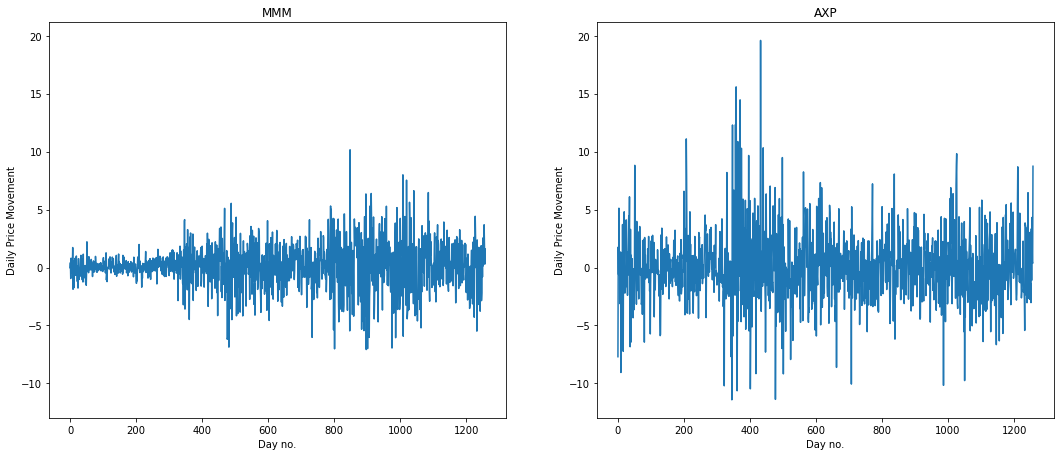

In [6]:
#Exploratory Data Analysis
plt.figure(figsize=(18,16))
ax1 = plt.subplot(221)
plt.plot(movements[0][:])
plt.xlabel('Day no.')
plt.ylabel('Daily Price Movement')
plt.title(tickers[0])

plt.subplot(222, sharey=ax1)
plt.plot(movements[1][:])
plt.xlabel('Day no.')
plt.ylabel('Daily Price Movement')
plt.title(tickers[1])
plt.show()


## Normalising the Data
Normalizing the daily stock price movements ensures that the K-Means algorithm works effectively and provides meaningful clusters. The Normalizer scales the data such that each row (representing a company's daily stock movements) has a Euclidean norm of 1. This process is also referred to as "feature scaling" and is a standard practice in data preprocessing for machine learning and clustering tasks.

In [7]:
# create the Normalizer
normalizer = Normalizer()

new = normalizer.fit_transform(movements)

print(new.max())
print(new.min())
print(new.mean())

0.20672244356694033
-0.21372320545961776
-5.940360998430062e-06


## K-Means
In this code, daily stock price movements are clustered into 10 groups using K-Means after normalizing the data for consistent scaling. The K-Means algorithm assigns each data point to a cluster, aiming to minimize the distance between data points and their respective cluster centers. The use of a normalization step is vital to ensure that all features are on the same scale, preventing any single feature from dominating the clustering process. The reported inertia score helps gauge the quality of the clustering, with lower values indicating well-defined and compact clusters.

In [8]:
# define normalizer
normalizer = Normalizer()

# create a K-means model with 10 clusters
kmeans = KMeans(n_clusters=10, max_iter=1000)

# make a pipeline chaining normalizer and kmeans
pipeline = make_pipeline(normalizer,kmeans)

# fit pipeline to daily stock movements
pipeline.fit(movements)

print(kmeans.inertia_)
# Intertia is a score of how close each cluster is, so a lower inertia score is better. 
# In this case, we got a score of 9.5908.


C:\Users\adamm\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


9.535608468183382


### Predicting Cluster Labels
The script assigns cluster labels to daily stock price movements, associates them with company details, and presents the results in a DataFrame sorted by cluster labels for easy analysis and interpretation of the stock market's clustering patterns.

In [9]:
# predict cluster labels
labels = pipeline.predict(movements)

# create a DataFrame aligning labels & companies
df = pd.DataFrame({'labels': labels, 'companies': tickers, 'title': company, 'industry': industry})

# display df sorted by cluster labels
print(df.sort_values('labels'))

    labels companies                     title                        industry
4        0        BA                    Boeing           Aerospace and defense
18       0       MRK                     Merck         Pharmaceutical industry
7        0      CSCO                     Cisco          Information technology
11       0        HD                Home Depot                Home Improvement
6        1       CVX                   Chevron              Petroleum industry
27       1       WBA  Walgreens Boots Alliance                       Retailing
12       1       HON                 Honeywell                    Conglomerate
28       2       WMT                   Walmart                       Retailing
26       2         V                      Visa              Financial services
22       2       CRM                Salesforce          Information technology
16       2       JPM            JPMorgan Chase              Financial services
21       3        PG          Procter & Gamble      

## Principal Component Analysis (PCA)
This script uses PCA for dimensionality reduction and K-Means clustering to group companies based on their stock price movements into 10 clusters. It then presents the results in a DataFrame sorted by cluster labels, providing insights into the clustering patterns in the stock market data.

In [10]:
# visualize the results
reduced_data = PCA(n_components = 2).fit_transform(new)

# run kmeans on reduced data
kmeans = KMeans(n_clusters=10)
kmeans.fit(reduced_data)
labels = kmeans.predict(reduced_data)

# create DataFrame aligning labels & companies
df = pd.DataFrame({'labels': labels, 'companies': tickers, 'title': company, 'industry': industry})

# Display df sorted by cluster labels
print(df.sort_values('labels'))

C:\Users\adamm\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1332: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


    labels companies                     title                        industry
2        0      AMGN                     Amgen               Biopharmaceutical
3        0      AAPL                     Apple          Information technology
9        0       DIS                    Disney  Broadcasting and entertainment
28       1       WMT                   Walmart                       Retailing
22       1       CRM                Salesforce          Information technology
20       2       NKE                      Nike               Clothing industry
0        2       MMM                        3M                    Conglomerate
5        2       CAT               Caterpillar         Construction and mining
23       3       TRV                 Travelers                       Insurance
18       3       MRK                     Merck         Pharmaceutical industry
10       4        GS             Goldman Sachs              Financial services
25       4        VZ                   Verizon     T

### Visualisation
This code generates a visualization of K-Means clustering results for stock market movements. It plots decision boundaries, cluster centroids, and data points on a 2D plane. The colors represent different clusters, allowing you to see how companies are grouped based on their stock price movements. Axis labels indicate that the plot represents principal component 1 and principal component 2, which are the results of dimensionality reduction using PCA.

<Figure size 432x288 with 0 Axes>

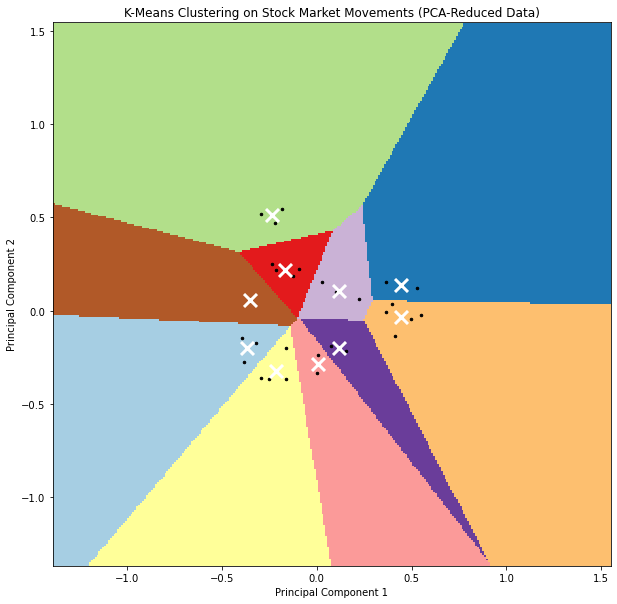

In [11]:
#Visualisation
# Define step size of mesh
h = 0.01

# plot the decision boundary
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:,0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:,1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain abels for each point in the mesh using our trained model
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

# define colorplot
cmap = plt.cm.Paired

# plot figure
plt.clf()
plt.figure(figsize=(10,10))
plt.imshow(Z, interpolation='nearest',
 extent = (xx.min(), xx.max(), yy.min(), yy.max()),
 cmap = cmap,
 aspect = 'auto', origin='lower')
plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=5)


# plot the centroid of each cluster as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
 marker='x', s=169, linewidth=3,
 color='w', zorder=10)

plt.title('K-Means Clustering on Stock Market Movements (PCA-Reduced Data)')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## Final Summary

In this code, we start by collecting and cleaning data related to stocks in the Dow Jones Industrial Average (DJIA). We then calculate the daily stock price movements, create a normalized version of the movements, and perform K-Means clustering to group companies based on their stock price behavior. Finally, we visualize the clustering results using PCA and K-Means, allowing us to observe how companies are grouped in the reduced-dimensional space.

Here's a detailed breakdown:

1. Data Collection and Cleaning:

Data for DJIA stocks is collected and cleaned, removing companies with missing data (NaN values) from consideration.

2. Stock Price Movement Calculation:

Daily stock price movements are calculated by subtracting the opening prices from the closing prices for each trading day.
A matrix ("movements") is created to store these movements for all companies.

3. Data Normalization:

The movements data is normalized using the sklearn Normalizer to scale the values.

4. K-Means Clustering:

A K-Means clustering model with ten clusters is created.
A pipeline is established, chaining the Normalizer and K-Means model.
The pipeline is fit to the daily stock movements, and the inertia score is calculated.

5. Cluster Labeling:

Cluster labels are predicted using the fitted K-Means model.
A DataFrame is created, aligning cluster labels with company information, such as tickers, company names, and industries.
The DataFrame is sorted based on cluster labels for analysis.

6. Principal Component Analysis (PCA):

The reduced data is calculated using PCA with two principal components.
K-Means clustering is applied to the reduced data to group companies based on their movements in a lower-dimensional space.
The results are displayed in a DataFrame.

7. Visualization:

A visual representation of the K-Means clustering results is generated.
Decision boundaries, data points, and cluster centroids are displayed on a 2D plane.
The plot provides insights into how companies are clustered based on their stock price movements, with axis labels indicating the principal components used in the visualization.

### Conclusion:
The provided code demonstrates a comprehensive data analysis and clustering process for DJIA stock price movements. It collects, cleans, and processes the data, performs K-Means clustering on the normalized movements, and visualizes the results using PCA reduction. This analysis enables a better understanding of how different companies are grouped based on their daily stock price behaviors, aiding investment and portfolio management decisions.